## Using EOBS + upscaling

Here we explore how to best extract areal averaged precipitation and test this for UK precipitation within SEAS5 and EOBS. The code is inspired on Matteo De Felice's [blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) -- credits to him!

We create a mask for all 241 countries within [Regionmask](https://regionmask.readthedocs.io/en/stable/#), that has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles). We use the mask to go from gridded precipitation to country-averaged timeseries. We regrid EOBS to the SEAS5 grid so we can select the same grid cells in calculating the UK average for both datasets. The country outline would not be perfect, but the masks would be the same so the comparison would be fair. 

I use the [xesmf package](https://xesmf.readthedocs.io/en/latest/) for upscaling, a good example can be found in this [notebook](https://nbviewer.jupyter.org/github/geoschem/GEOSChem-python-tutorial/blob/master/Chapter03_regridding.ipynb). 

### Import packages

We need the packages regionmask for masking and xesmf for regridding. I cannot install xesmf into the UNSEEN-open environment without breaking my environment, so in this notebook I use a separate 'upscale' environment, as suggested by this [issue](https://github.com/JiaweiZhuang/xESMF/issues/47#issuecomment-582421822). I use the packages esmpy=7.1.0 xesmf=0.2.1 regionmask cartopy matplotlib xarray numpy netcdf4. 

In [2]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [3]:
##import packages
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import regionmask       # Masking
import xesmf as xe      # Regridding

### Load SEAS5 and EOBS


From CDS, we [retrieve SEAS5](1.Download/1.Retrieve.ipynb) and here we merge the retrieved files (see more in [preprocessing](2.Preprocess/2.Preprocess.ipynb)). We create a netcdf file containing the dimensions lat, lon, time (35 years), number (25 ensembles) and leadtime (5 initialization months).

In [5]:
SEAS5 = xr.open_dataset('../UK_example/SEAS5/SEAS5_UK.nc')

And load EOBS netcdf with only February precipitation, resulting in 71 values, one for each year within 1950 - 2020 over the European domain (25N-75N x 40W-75E). 

In [6]:
EOBS = xr.open_dataset('../UK_example/EOBS/EOBS_UK.nc')
EOBS

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 71)
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
Data variables:
    rr         (time, latitude, longitude) float32 ...

### Masking
Here we load the countries and create a mask for SEAS5 and for EOBS. 

Regionmask has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles).

In [7]:
countries = regionmask.defined_regions.natural_earth.countries_50
countries

241 'Natural Earth Countries: 50m' Regions (http://www.naturalearthdata.com)
ZW ZM YE VN VE V VU UZ UY FSM MH MP VI GU AS PR US GS IO SH PN AI FK KY BM VG TC MS JE GG IM GB AE UA UG TM TR TN TT TO TG TL TH TZ TJ TW SYR CH S SW SR SS SD LK E KR ZA SO SL SB SK SLO SG SL SC RS SN SA ST RSM WS VC LC KN RW RUS RO QA P PL PH PE PY PG PA PW PK OM N KP NG NE NI NZ NU CK NL AW CW NP NR NA MZ MA WS ME MN MD MC MX MU MR M ML MV MY MW MG MK L LT FL LY LR LS LB LV LA KG KW KO KI KE KZ J J J I IS PAL IRL IRQ IRN INDO IND IS HU HN HT GY GW GN GT GD GR GH D GE GM GA F PM WF MF BL PF NC TF AI FIN FJ ET EST ER GQ SV EG EC DO DM DJ GL FO DK CZ CN CY CU HR CI CR DRC CG KM CO CN MO HK CL TD CF CV CA CM KH MM BI BF BG BN BR BW BiH BO BT BJ BZ B BY BB BD BH BS AZ A AU IOT HM NF AU ARM AR AG AO AND DZ AL AF SG AQ SX

Now we create the mask for the SEAS5 grid. Only one timestep is needed to create the mask. This mask will lateron be used to mask all the timesteps. 

In [8]:
SEAS5_mask = countries.mask(SEAS5.sel(leadtime=2, number=0, time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')

And create a plot to illustrate what the mask looks like. The mask just indicates for each gridcell what country the gridcell belongs to.

<xarray.DataArray 'region' (latitude: 11, longitude: 14)>
array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  31.,  nan,  31.,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan, 140.,  31.,  31.,  31.,  31.,  31.,  31.,  nan,
         nan,  nan,  nan],
       [ nan, 140., 140., 140., 140.,  nan,  nan,  nan,  nan,  31.,  31.,
         nan,  nan,  nan],
       [ nan,  nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  nan,  nan],
       [ nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,  31.,
         31.,  31.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  31., 160.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan, 160.]])
Coordinates:
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0

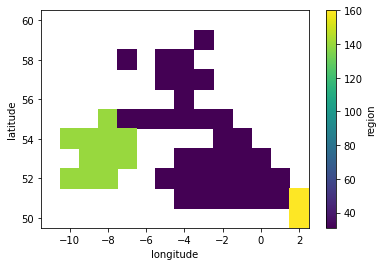

In [9]:
SEAS5_mask
SEAS5_mask.plot()

And now we can extract the UK averaged precipitation within SEAS5 by using the mask index of the UK: `where(SEAS5_mask == UK_index)`. 
So we need to find the index of one of the 241 abbreviations. In this case for the UK use 'GB'. Additionally, if you can't find a country, use `countries.regions` to get the full names of the countries.
 

In [10]:
countries.abbrevs.index('GB')

31

To select the UK average, we select SEAS5 precipitation (tprate), select the gridcells that are within the UK and take the mean over those gridcells. This results in a dataset of February precipitation for 35 years (1981-2016), with 5 leadtimes and 25 ensemble members.

In [11]:
SEAS5_UK = (SEAS5['tprate']
            .where(SEAS5_mask == 31)
            .mean(dim=['latitude', 'longitude']))
SEAS5_UK

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'tprate' (leadtime: 5, time: 39, number: 51)>
array([[[1.7730116 , 1.9548205 , 3.7803986 , ...,        nan,
                nan,        nan],
        [3.040877  , 1.8855734 , 4.2009687 , ...,        nan,
                nan,        nan],
        [3.556001  , 3.6879914 , 3.184576  , ...,        nan,
                nan,        nan],
        ...,
        [2.9507504 , 2.789885  , 3.252184  , ..., 1.8537003 ,
         3.002799  , 3.8576229 ],
        [2.9951687 , 3.872034  , 3.8536534 , ..., 3.5534801 ,
         2.4795628 , 3.5001822 ],
        [1.6970206 , 1.3571059 , 2.7251225 , ..., 3.535101  ,
         3.3363144 , 3.8510854 ]],

       [[1.0868028 , 1.5332695 , 3.2461395 , ...,        nan,
                nan,        nan],
        [0.99898285, 2.9119303 , 2.1601522 , ...,        nan,
                nan,        nan],
        [3.6581304 , 3.5088263 , 2.0143754 , ...,        nan,
                nan,        nan],
        ...,
        [2.2972794 , 2.6159883 , 1.2061493 , ..., 2.6729386 ,
         2.8370278 , 3.2695346 ],
        [5.094759  , 2.7528167 , 1.9417399 , ..., 3.5889919 ,
         1.525842  , 3.0035791 ],
        [3.240109  , 4.146352  , 2.9840755 , ..., 3.131607  ,
         3.634821  , 2.8452704 ]],

       [[2.0119116 , 2.4435556 , 1.3927166 , ...,        nan,
                nan,        nan],
        [2.62523   , 3.6218376 , 3.003645  , ...,        nan,
                nan,        nan],
        [4.071685  , 2.6880858 , 3.8181992 , ...,        nan,
                nan,        nan],
        ...,
        [4.18686   , 2.4341922 , 2.3860729 , ..., 3.6107152 ,
         2.654895  , 1.8162413 ],
        [1.2847987 , 2.8927827 , 2.3829966 , ..., 4.846281  ,
         2.2673166 , 2.598539  ],
        [2.4176307 , 2.826758  , 1.9144063 , ..., 2.3856838 ,
         2.0960681 , 1.6105822 ]],

       [[2.9105136 , 3.6938024 , 1.1343408 , ...,        nan,
                nan,        nan],
        [4.02007   , 1.8249133 , 3.099     , ...,        nan,
                nan,        nan],
        [3.1248841 , 2.219241  , 3.6903172 , ...,        nan,
                nan,        nan],
        ...,
        [3.1467083 , 5.082951  , 2.9249673 , ..., 2.0092194 ,
         2.544652  , 3.8257258 ],
        [2.3694625 , 3.578296  , 3.527209  , ..., 3.950293  ,
         2.9967482 , 1.6948671 ],
        [4.3424473 , 5.037247  , 2.4635391 , ..., 2.5078914 ,
         2.767472  , 2.4778244 ]],

       [[3.1285267 , 3.269652  , 2.5995293 , ...,        nan,
                nan,        nan],
        [2.262867  , 3.3503478 , 2.4287066 , ...,        nan,
                nan,        nan],
        [4.0569496 , 2.156282  , 1.781804  , ...,        nan,
                nan,        nan],
        ...,
        [2.1076744 , 1.7262052 , 1.8901306 , ..., 3.2577527 ,
         3.3160198 , 1.7766333 ],
        [2.7879143 , 3.5520785 , 1.695757  , ..., 2.852018  ,
         3.3634171 , 2.9967682 ],
        [3.836647  , 2.7460904 , 4.5292573 , ..., 2.7118914 ,
         2.7603571 , 4.0256233 ]]], dtype=float32)
Coordinates:
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2020-02-01
  * leadtime  (leadtime) int64 2 3 4 5 6

However, xarray does not take into account the area of the gridcells in taking the average. Therefore, we have to calculate the area-weighted mean of the gridcells. To calculate the area of each gridcell, I use cdo `cdo gridarea infile outfile`. Here I load the generated file:

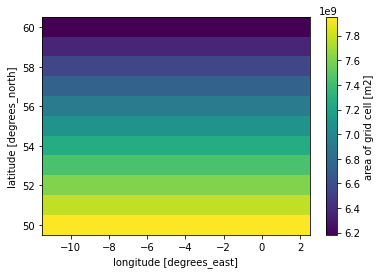

In [12]:
Gridarea_SEAS5 = xr.open_dataset('../UK_example/Gridarea_SEAS5.nc')
Gridarea_SEAS5['cell_area'].plot()

In [13]:
SEAS5_UK_weighted = (SEAS5['tprate']
                  .where(SEAS5_mask == 31)
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
SEAS5_UK_weighted

<xarray.DataArray (leadtime: 5, time: 39, number: 51)>
array([[[1.74715784, 1.91625164, 3.74246331, ...,        nan,
                nan,        nan],
        [3.01557164, 1.86355946, 4.23964218, ...,        nan,
                nan,        nan],
        [3.45037457, 3.67373672, 3.19124952, ...,        nan,
                nan,        nan],
        ...,
        [2.93410386, 2.74606084, 3.18639043, ..., 1.75603451,
         2.92185771, 3.83075713],
        [2.99583296, 3.88464775, 3.8476675 , ..., 3.51473106,
         2.43278432, 3.47741487],
        [1.70198039, 1.34639466, 2.70610296, ..., 3.45445812,
         3.2937839 , 3.80084943]],

       [[1.08925258, 1.502868  , 3.23383862, ...,        nan,
                nan,        nan],
        [0.96385251, 2.9144073 , 2.14176199, ...,        nan,
                nan,        nan],
        [3.64189637, 3.44186084, 1.96817031, ...,        nan,
                nan,        nan],
        ...,
        [2.26289577, 2.64050615, 1.18109141, ..., 2.64159823,
         2.78090027, 3.29229504],
        [5.05480192, 2.7228239 , 1.9085107 , ..., 3.56878426,
         1.46244825, 2.97974057],
        [3.19406732, 4.0754389 , 2.89935002, ..., 3.16283376,
         3.65486179, 2.7700864 ]],

       [[1.94362083, 2.4160058 , 1.36431312, ...,        nan,
                nan,        nan],
        [2.57294707, 3.55756557, 2.96458594, ...,        nan,
                nan,        nan],
        [4.13926899, 2.61380816, 3.76440713, ...,        nan,
                nan,        nan],
        ...,
        [4.12634415, 2.40580538, 2.30931212, ..., 3.60437091,
         2.65663573, 1.78742804],
        [1.26374643, 2.86376533, 2.36735188, ..., 4.80009495,
         2.22897541, 2.58805634],
        [2.37179549, 2.86106518, 1.90401998, ..., 2.40591114,
         2.08595829, 1.55529216]],

       [[2.83876303, 3.61651907, 1.0950032 , ...,        nan,
                nan,        nan],
        [3.95351432, 1.78778573, 3.08959013, ...,        nan,
                nan,        nan],
        [3.13152664, 2.19419128, 3.64975772, ...,        nan,
                nan,        nan],
        ...,
        [3.06984433, 4.99797376, 2.88955225, ..., 1.97087261,
         2.52861605, 3.75363435],
        [2.36128612, 3.52506141, 3.50087731, ..., 3.93962213,
         2.94645673, 1.69376439],
        [4.35700042, 5.02027928, 2.46636484, ..., 2.46297193,
         2.74433285, 2.45057078]],

       [[3.15063505, 3.23490175, 2.60923731, ...,        nan,
                nan,        nan],
        [2.21017692, 3.32458317, 2.3819878 , ...,        nan,
                nan,        nan],
        [4.07655988, 2.07606666, 1.75961194, ...,        nan,
                nan,        nan],
        ...,
        [2.11429562, 1.68735339, 1.84325489, ..., 3.26149299,
         3.32371077, 1.78717855],
        [2.75385495, 3.4979577 , 1.66987709, ..., 2.85354534,
         3.40446786, 3.01953669],
        [3.81460036, 2.70650167, 4.54162104, ..., 2.69608025,
         2.73558576, 4.04264194]]])
Coordinates:
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2020-02-01
  * leadtime  (leadtime) int64 2 3 4 5 6

Another solution is to take the cosine of the latitude, which is proportional to the grid cell area for regular latitude/ longitude grids [(xarray example)](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html). This should be the same as the previous example, but easier to reproduce.

In [14]:
area_weights = np.cos(np.deg2rad(SEAS5.latitude))
SEAS5_UK_weighted_latcos = (SEAS5['tprate']
                  .where(SEAS5_mask == 31)
                  .weighted(area_weights) 
                  .mean(dim=['latitude', 'longitude'])
                 )

I plot the UK average for ensemble member 0 and leadtime 2 to show that the the two methods for taking an average are the same. 
Furthermore, the difference between the weighted and non-weighted average is very small in this case. The difference would be greater for larger domains and further towards to poles.  

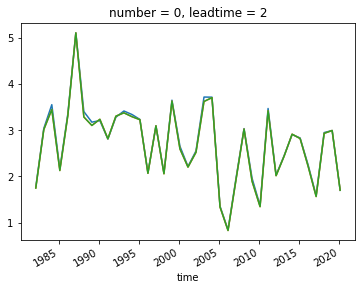

In [15]:
SEAS5_UK.sel(leadtime=2,number=0).plot()
SEAS5_UK_weighted.sel(leadtime=2,number=0).plot()
SEAS5_UK_weighted_latcos.sel(leadtime=2,number=0).plot()


### Upscale
For EOBS, we want to upscale the dataset to the SEAS5 grid. We use the function `regridder(ds_in,ds_out,function)`, see the [docs](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html). We have to rename the lat lon dimensions so the function can read them. 

We use bilinear interpolation first (i.e. function = 'bilinear'), because of its ease in implementation. However, the use of conservative areal average (function = 'conservative') for upscaling is preferred ([Kopparla, 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013GL057866)). 

In [16]:
regridder = xe.Regridder(EOBS.rename({'longitude': 'lon', 'latitude': 'lat'}), SEAS5.rename({'longitude': 'lon', 'latitude': 'lat'}),'bilinear')

Overwrite existing file: bilinear_201x464_11x14.nc 
 You can set reuse_weights=True to save computing time.


Now that we have the regridder, we can apply the regridder to our EOBS dataarray:

In [17]:
EOBS_upscaled = regridder(EOBS)
EOBS_upscaled

using dimensions ('latitude', 'longitude') from data variable rr as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (lat: 11, lon: 14, time: 71)
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
  * lon      (lon) float32 -11.0 -10.0 -9.0 -8.0 -7.0 ... -2.0 -1.0 0.0 1.0 2.0
  * lat      (lat) float32 60.0 59.0 58.0 57.0 56.0 ... 54.0 53.0 52.0 51.0 50.0
Data variables:
    rr       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan 4.243
Attributes:
    regrid_method:  bilinear

And set the latlon dimension names back to their long name. This is so both SEAS5 and EOBS have the same latlon dimension names which is necessary when using the same mask.  

In [18]:
EOBS_upscaled = EOBS_upscaled.rename({'lon' : 'longitude', 'lat' : 'latitude'})

### Illustrate the SEAS5 and EOBS masks for the UK

Here I plot the masked mean SEAS5 and upscaled EOBS precipitation. This shows that upscaled EOBS does not contain data for all gridcells within the UK mask (the difference between SEAS5 gridcells and EOBS gridcells with data). We can apply an additional mask for SEAS5 that masks the grid cells that do not contain data in EOBS. 

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

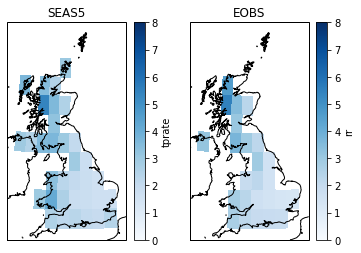

In [19]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].where(SEAS5_mask == 31).mean(
    dim=['time', 'leadtime', 'number']).plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])

EOBS_upscaled['rr'].where(SEAS5_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

The additional mask of SEAS5 is where EOBS is not null:

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

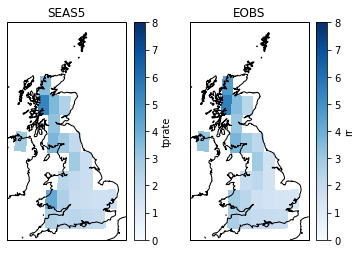

In [20]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

(SEAS5['tprate']
 .where(SEAS5_mask == 31)
 .where(EOBS_upscaled['rr'].sel(time='1950').squeeze('time').notnull()) ## mask values that are nan in EOBS
 .mean(dim=['time', 'leadtime', 'number'])
 .plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])
)

EOBS_upscaled['rr'].where(SEAS5_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')



Let's include the 2020 event

In [21]:
EOBS2020_sd_anomaly = EOBS_upscaled['rr'].sel(time='2020') - EOBS_upscaled['rr'].mean('time') / EOBS_upscaled['rr'].std('time')
EOBS2020_sd_anomaly.attrs = {
    'long_name': 'Precipitation anomaly',
    'units': '-'
}
EOBS2020_sd_anomaly

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'rr' (time: 1, latitude: 11, longitude: 14)>
array([[[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan, 3.95092072,        nan,        nan,        nan,
                nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan, 4.59428102, 3.79702769, 1.96181425,        nan,
                nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan, 4.71781348, 5.2826348 ,        nan,        nan,
                nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan, 4.40361314,
                nan,        nan, 5.47361673, 6.10292013, 3.78611734,
                nan,        nan,        nan,        nan],
        [       nan,        nan, 6.8501372 , 6.14007146, 4.30546062,
                nan,        nan,        nan,        nan, 3.68873396,
         2.38060983,        nan,        nan,        nan],
        [       nan,        nan,        nan, 5.73786063, 4.37045386,
                nan,        nan,        nan, 2.70572296, 3.11985962,
         3.02861986,        nan,        nan,        nan],
        [       nan, 5.81172535, 5.30645502,        nan,        nan,
                nan,        nan, 3.13110123, 3.03169002, 2.42073797,
         2.30607803, 1.0535416 , 0.16921805,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan, 3.97998605, 3.35993006, 2.88487988,
         3.06793855, 1.90991066,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 2.58264812]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-02-29
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
Attributes:
    long_name:  Precipitation anomaly
    units:      -

<Figure size 237.6x288 with 0 Axes>

Text(0.5, 1.0, 'February 2020')

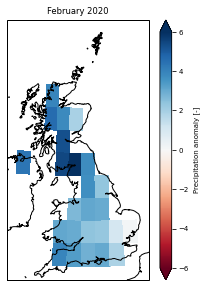

In [50]:
plt.figure(figsize=(3.3, 4))
plt.rc('font', size=7) #controls default text size

ax = plt.axes(projection=ccrs.OSGB())

EOBS2020_sd_anomaly.where(SEAS5_mask == 31).plot(
    transform=ccrs.PlateCarree(),
    vmin = -6,
    vmax = 6,    
    extend = 'both',
    cmap = plt.cm.RdBu,#twilight_shifted_r,#plt.cm.Blues,#
    ax=ax)

ax.coastlines(resolution='10m')
# gl = ax.gridlines(crs=ccrs.PlateCarree(),
#                   draw_labels=False,     # cannot label OSGB projection..
#                   linewidth=1,
#                   color='gray',
#                   alpha=0.5,
#                   linestyle='--')
    
ax.set_title('February 2020')
plt.tight_layout()
plt.savefig('graphs/UK_event_selection2.png', dpi=300)

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'rr' (time: 1, latitude: 201, longitude: 464)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 2020-02-29
Attributes:
    long_name:  Precipitation anomaly
    units:      -

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'February 2020')

Text(0.5, 1.0, 'SEAS5 average')

Text(0.5, 1.0, 'EOBS average')

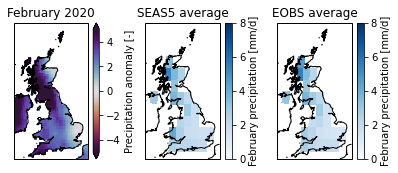

In [101]:
EOBS2020_sd_anomaly = EOBS['rr'].sel(time='2020') - EOBS['rr'].mean('time') / EOBS['rr'].std('time')
EOBS2020_sd_anomaly.attrs = {
    'long_name': 'Precipitation anomaly',
    'units': '-'
}
EOBS2020_sd_anomaly


fig, axs = plt.subplots(1, 3, figsize=(6.7,2.5),subplot_kw={'projection': ccrs.OSGB()}) #figsize=(10.,6.),

EOBS2020_sd_anomaly.plot(
    transform=ccrs.PlateCarree(),
    robust=True,
    extend = 'both',
    cmap=plt.cm.twilight_shifted_r,
    ax=axs[0])

(SEAS5['tprate']
 .where(SEAS5_mask == 31)
 .where(EOBS_upscaled['rr'].sel(time='1950').squeeze('time').notnull()) ## mask values that are nan in EOBS
 .mean(dim=['time', 'leadtime', 'number'])
 .plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1],
    cbar_kwargs={'label': 'February precipitation [mm/d]'}
 )
)

EOBS_upscaled['rr'].where(SEAS5_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[2],
    cbar_kwargs={'label': 'February precipitation [mm/d]'}
)


for ax in axs.flat:
    ax.coastlines(resolution='10m')
#     ax.set_aspect('auto')


axs[0].set_title('February 2020')
axs[1].set_title('SEAS5 average')
axs[2].set_title('EOBS average')

# fig.set_figwidth(180/26)
# plt.savefig('graphs/UK_event_selection.pdf', dpi=300)

### Extract the spatial average

To select the UK average, we select SEAS5 precipitation (tprate), select the gridcells that are within the UK and take the area-weighted mean over those gridcells. This results in a dataset of February precipitation for 35 years (1981-2016), with 5 leadtimes and 25 ensemble members.

In [31]:
SEAS5_UK_weighted = (SEAS5
                  .where(SEAS5_mask == 31)
                  .where(EOBS_upscaled['rr'].sel(time='1950').squeeze('time').notnull())
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
SEAS5_UK_weighted

<xarray.Dataset>
Dimensions:   (leadtime: 5, number: 51, time: 39)
Coordinates:
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2020-02-01
  * leadtime  (leadtime) int64 2 3 4 5 6
Data variables:
    tprate    (leadtime, time, number) float64 1.62 1.803 3.715 ... 2.564 4.138

<xarray.Dataset>
Dimensions:  (time: 71)
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
Data variables:
    rr       (time) float64 4.127 3.251 1.072 1.593 ... 2.774 1.498 1.782 4.92

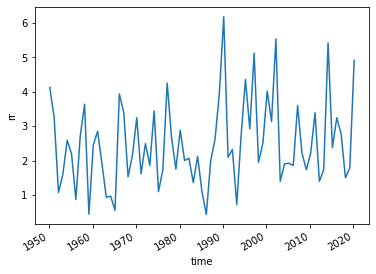

In [32]:
EOBS_UK_weighted = (EOBS_upscaled
                  .where(SEAS5_mask == 31) ## EOBS is now on the SEAS5 grid, so use the SEAS5 mask and gridcell area
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
EOBS_UK_weighted
EOBS_UK_weighted['rr'].plot()

### Illustrate the SEAS5 and EOBS UK average

And the area-weighted average UK precipitation for SEAS5 and EOBS I plot here. For SEAS5 I plot the range, both min/max and the 2.5/97.5 % percentile of all ensemble members and leadtimes for each year.  

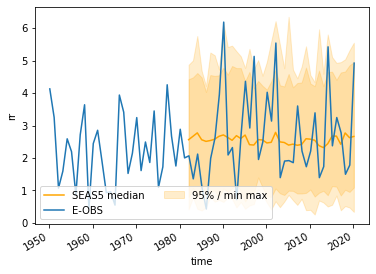

In [33]:
ax = plt.axes()

Quantiles = (SEAS5_UK_weighted['tprate']
             .quantile([0,2.5/100, 0.5, 97.5/100,1],
                       dim=['number','leadtime']
                      )
            )
ax.plot(Quantiles.time, Quantiles.sel(quantile=0.5),
        color='orange',
        label = 'SEAS5 median')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975),
                color='orange',
                alpha=0.2,
                label = '95% / min max')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1),
                color='orange',
                alpha=0.2)

EOBS_UK_weighted['rr'].plot(ax=ax,
                            x='time',
                            label = 'E-OBS')
plt.legend(loc = 'lower left',
           ncol=2 ) #loc = (0.1, 0) upper left

### And save the UK weighted average datasets


In [34]:
SEAS5_UK_weighted.to_netcdf('Data/SEAS5_UK_weighted_masked.nc')
SEAS5_UK_weighted.to_dataframe().to_csv('Data/SEAS5_UK_weighted_masked.csv')
EOBS_UK_weighted.to_netcdf('Data/EOBS_UK_weighted_upscaled.nc') ## save as netcdf
EOBS_UK_weighted.to_dataframe().to_csv('Data/EOBS_UK_weighted_upscaled.csv') ## and save as csv. 

In [35]:
SEAS5_UK_weighted.close()
EOBS_UK_weighted.close()

### Other methods
There are many different sources and methods available for extracting areal-averages from shapefiles. Here I have used shapely / masking in xarray. Something that lacks with this method is the weighted extraction from a shapefile, that is more precise on the boundaries. In R, raster:extract can use the percentage of the area that falls within the country for each grid cell to use as weight in averaging. For more information on this method, see the [EGU 2018 course](https://github.com/hydrosoc/rhydro_EGU18/blob/master/netCDF.pdf). For SEAS5, with its coarse resolution, this might make a difference. However, for it's speed and reproducibility, we have chosen to stick to xarray. 

We have used xarray where you can apply weights yourself to a dataset and then calculate the weighted mean. Sources I have used:
* [xarray weighted reductions](http://xarray.pydata.org/en/stable/computation.html#weighted-array-reductions) 
* [Matteo's blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) 
* [regionmask package](https://regionmask.readthedocs.io/en/stable/#) 
* [Arctic weighted average example](https://nordicesmhub.github.io/NEGI-Abisko-2019/training/Example_model_global_arctic_average.html)
* [area weighted temperature example](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html).

And this pretty [awesome colab notebook](https://colab.research.google.com/drive/1wWHz_SMCHNuos5fxWRUJTcB6wqkTJQCR#scrollTo=B8PyoC1vXvd-) on seasonal forecasting regrids seasonal forecasts and reanalysis on the same grid before calculating skill scores. 